# Advanced Machine Learning 2024/2025 - PyTorch Crash Course

**Teaching Assistant**: Simone Alberto Peirone

Inspired by: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

The goal of this notebook is to train a very basic neural network on the CIFAR 10 dataset.

Then, you can modify the dataset and the training loop to extend the code to a new dataset: Flowers.

In [23]:
import torch
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

import tqdm.auto as tqdm

## Training a network on CIFAR10

### Dataset preparation

In [24]:
# Transformations to be applied to the output of the dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

# Training dataset and dataloader
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=2)

# Test dataset and dataloader
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170M/170M [01:00<00:00, 2.83MB/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


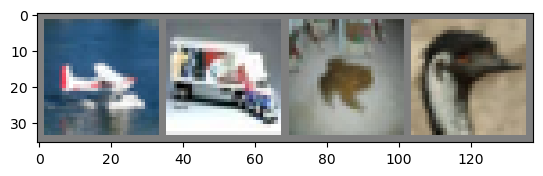

Labels: plane, truck, frog, bird


In [25]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)

# TODO: what's the content of images and labels?
# How are multiple images batched together
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print('Labels: ' + ', '.join(f'{classes[labels[j]].strip()}' for j in range(batch_size)))

## Network definition

Let's define a very basic neural network that takes an image as input and outputs one out of 10 labels.

In [26]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self, n_classes: int = 10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, n_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net(n_classes=10)#.cuda()

print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


## Optimizers

In [27]:
import torch.optim as optim

optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## Training loop

In [28]:
for epoch in range(2):  # Loop over the dataset twice

    for i, (inputs, labels) in enumerate(trainloader):

        # inputs, labels = inputs, labels

        # inputs, labels = inputs.cuda(), labels.cuda()
        # zero the parameter gradients
        optimizer.zero_grad()

        # Forward the input through the network
        logits = net(inputs)

        # Compute the loss value for the input
        loss = F.cross_entropy(logits, labels)

        # Compute gradients of the loss with respect to the model parameters
        loss.backward()

        # Apply gradient updates
        optimizer.step()

        if i % 1000 == 0:    # print every 2000 mini-batches
            print(f'Training loss: {loss.item():.3f}')


Training loss: 2.301
Training loss: 2.276
Training loss: 2.327
Training loss: 1.522
Training loss: 1.336
Training loss: 1.819
Training loss: 1.318
Training loss: 1.203
Training loss: 1.408
Training loss: 1.622
Training loss: 1.221
Training loss: 1.365
Training loss: 1.195
Training loss: 2.126
Training loss: 0.862
Training loss: 1.454
Training loss: 1.072
Training loss: 0.646
Training loss: 0.913
Training loss: 1.363
Training loss: 1.287
Training loss: 0.125
Training loss: 1.949
Training loss: 1.060
Training loss: 1.478
Training loss: 1.136


### BONUS: what happens after you call loss.backward()?

Try to inspect the `.grad` property of the network's parameters.

In [29]:
inputs, labels = next(iter(trainloader))
# inputs, labels = inputs.cuda(), labels.cuda()

# zero the parameter gradients
optimizer.zero_grad()

# Forward the input through the network
logits = net(inputs)

# Compute the loss value for the input
loss = F.cross_entropy(logits, labels)

# Compute the gradients
loss.backward()

net.parameters()

<generator object Module.parameters at 0x7f62e81ed700>

## Validate the network on the test data

In [30]:
correct = 0
total = 0

with torch.no_grad():

    for inputs, labels in testloader:
        # inputs, labels = inputs.cuda(), labels.cuda()

        # Compute the network logits for the input batch
        outputs = net(inputs) # B x num_classes

        # For each input sample in the batch, we predict the class corresponding to the larget logit
        predicted_labels = outputs.max(1).indices

        total += labels.size(0)
        correct += (predicted_labels == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f} %')

Accuracy of the network on the 10000 test images: 55.38 %


## Extension to a new dataset

**It's your turn!**.

Download the Flowers dataset from http://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz

In [31]:
!wget http://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz
!wget http://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat
!wget http://www.robots.ox.ac.uk/~vgg/data/flowers/102/setid.mat
!tar -xf 102flowers.tgz && rm 102flowers.tgz

--2024-12-05 11:07:01--  http://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz [following]
--2024-12-05 11:07:01--  https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/flowers/102/102flowers.tgz [following]
--2024-12-05 11:07:01--  https://thor.robots.ox.ac.uk/flowers/102/102flowers.tgz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Leng

In [48]:
import os.path as osp
from torch.utils.data import Dataset

from typing import Literal
from PIL import Image
from torchvision.io import read_image

import scipy.io


class FlowersDataset(Dataset):
    def __init__(self, split: Literal['trn', 'val', 'tst'],
                 labels_file: str, splits_path: str, img_dir: str, transform=None):
        self.split = split
        self.ids = np.array(scipy.io.loadmat('setid.mat')[f'{split}id']).squeeze()

        # Load the labels
        labels = np.array(scipy.io.loadmat('imagelabels.mat')['labels'].squeeze())
        self.labels = np.take(labels, self.ids, 0)

        self.img_dir = img_dir

        self.transform = transform

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        image = Image.open(osp.join(self.img_dir, f'image_{self.ids[idx]:0>5}.jpg'))
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [49]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.Resize(64),
    transforms.CenterCrop(64)
])

trainset = FlowersDataset("trn", "imagelabels.mat", "setid.mat", "jpg", transform=transform)
valset = FlowersDataset("val", "imagelabels.mat", "setid.mat", "jpg", transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=True, num_workers=2)

In [50]:
class Net(nn.Module):
    def __init__(self, n_classes: int = 10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 128, 5)
        self.avgpool = nn.AdaptiveAvgPool2d(2)
        self.fc1 = nn.Linear(512, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, n_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = F.relu(self.conv2(x))
        x = self.avgpool(x)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)


net = Net(n_classes=103)#.cuda()

optimizer = optim.Adam(net.parameters(), lr=0.001)

In [51]:
for epoch in range(10):  # Loop over the dataset twice

    for i, (inputs, labels) in enumerate(trainloader):

        # inputs, labels = inputs.cuda(), labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # Forward the input through the network
        logits = net(inputs)

        # Compute the loss value for the input
        loss = F.cross_entropy(logits, labels)

        # Compute gradients of the loss with respect to the model parameters
        loss.backward()

        # Apply gradient updates
        optimizer.step()

        if i % 1000 == 0:    # print every 2000 mini-batches
            print(f'Training loss: {loss.item():.3f}')


Training loss: 4.654
Training loss: 4.510
Training loss: 3.811
Training loss: 4.048
Training loss: 4.441
Training loss: 3.836
Training loss: 3.557
Training loss: 3.832
Training loss: 4.585
Training loss: 2.926


In [52]:
correct = 0
total = 0

with torch.no_grad():

    for inputs, labels in valloader:
        # inputs, labels = inputs.cuda(), labels.cuda()

        # Compute the network logits for the input batch
        outputs = net(inputs)

        # For each input sample in the batch, we predict the class corresponding to the larget logit
        predicted_labels = outputs.max(1).indices

        total += labels.size(0)
        correct += (predicted_labels == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct / total:.2f} %')

Accuracy of the network on the test images: 13.14 %
